In [ ]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
np.random.seed(seed=217)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Cleaning

In [ ]:
train = pd.read_csv("../input/costa-rican-household-poverty-prediction/train.csv")
test = pd.read_csv("../input/costa-rican-household-poverty-prediction/test.csv")

In [ ]:
train 

9557 rows and 143 columns for train data, consistent with the description from host

In [ ]:
test

In [ ]:
train[train.age >= 18].groupby('idhogar').transform("count")

23856 rows and 142 columns for test data, consistent with the description from host

In [ ]:
train_test = train.append(test, ignore_index = True)
train_test

notice that 'Target' with NaN is from test data

check for id and idhodgar uniqueness. 

In [ ]:
train_test['Id'].value_counts()

id is unique

In [ ]:
train_test['idhogar'].value_counts()

there are 10340 households in the dataset

saw a lot of columns with similar name, check if they are mutually exclusive/ one hot encoded data.

In [ ]:
#check if multiple columns can be 1 at the same time
#all the columns should only contains binary data 1 or 0
def is_mutually_exclusive(dataframe,attributes):
    res_s = dataframe[attributes].sum(axis=1)
    res_s = res_s[res_s > 1]
    if res_s.size == 0:
        print(attributes,'are mutually exclusive')
    else:
        print(attributes,'are not mutually exclusive')

In [ ]:
suspected_columns_in_ohe = ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 
                            'energ', 'elimbasu','epared', 'etecho', 'eviv', 
                            'estadocivil', 'parentesco','instlevel','tipovivi','lugar']
electricity_source = ['public','planpri', 'noelec', 'coopele']
for group_title in suspected_columns_in_ohe:
    group = [col for col in train_test if col.startswith(group_title)]
    is_mutually_exclusive(train_test, group)
is_mutually_exclusive(train_test, electricity_source)

all are mutually exclusive. or one hot encoded data. Can change to label encoding when doing feature engineering if we are building decision tree.

check empty data for every column 

In [ ]:
missing = pd.DataFrame(train_test.isnull().sum()).rename(columns={0:'total'})
missing['Percent']=missing['total']/len(train_test)
missing.sort_values('Percent',ascending=False).head(10)

In [ ]:
train_test.loc[((train_test['age']>19) | (train_test['age']<7)) & (train_test['rez_esc'].isnull()), 'rez_esc']=0


rez_esc -> Years behind in school

According to the Host "This variable is only collected for people between 7 and 19 years of age and it is the difference between the years of education a person should have and the years of education he/she has. it is capped at 5."

In [ ]:
missing_rez_esc = train_test[train_test['rez_esc'].isnull() == True]
missing_rez_esc = missing_rez_esc[['rez_esc','age','escolari']]
print(missing_rez_esc.to_string())

The rez_esc that are still missing are mostly by individual aged 18-19. I assumed they are graduated from school or won't be attending school anymore. Hence, years behind in school are not applicable to them as well and we can fill their 'rez_esc' as 0.

In [ ]:
train_test['rez_esc']=train_test['rez_esc'].fillna(0)

In [ ]:
over_rez_esc = train_test[train_test['rez_esc'] > 5]
over_rez_esc= over_rez_esc[['rez_esc','age','escolari']]
print(over_rez_esc.to_string())

Only one individual has 'rez_esc' > 5. 
This is an invalid data because years behind in school is 99 years but the individual is only 8 years old.
We shall replace the rez_esc with '8 - 7 - escolari'. We assumed that age - 7 give the years of education a person should have.

In [ ]:
train_test.loc[train_test['rez_esc'] > 5, 'rez_esc'] = 8 - 7 - 0

v18q1 is Number of tablets household owns. 
v18q is binary data showing if a household owns a tablet.

In [ ]:
train_test.groupby('v18q')['v18q1'].apply(lambda x:x.isnull().sum())

all 25468 missing data in 'v18q1' is when 'v18q' equals to 0. meaning that the household dont own a tablet and also means that the number of tablets the household owns is 0 ('v18q1' = 0). Hence, fill in the empty data in 'v18q1' to 0. 

In [ ]:
train_test['v18q1']=train_test['v18q1'].fillna(0)

Accodint to the host : "In the example of v2a1 you should first filter by tipoviv3. Most households that don't have information will be households that do not rent or are not paying loans (tipoviv2). If a household is tipoviv3 and does not have information then you need to make a choice about the treatment of the variable either assume 0, impute a value or not use the variable. Basically in those cases we don't know the value."

In [ ]:
import matplotlib.pyplot as plt
own_variables=[x for x in train_test if x.startswith('tipo')]
train_test.loc[train_test['v2a1'].isnull(),own_variables].sum().plot.bar()
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)

* No empty 'v2a1' when tipovivi2 and tipovivi3 ==1. 
* Empty 'v2a1' are mostly coming from tipovivi1 menaning that owns a fully paid house so dont need to pay rent
* assume that the individual dont need to pay rent for the others empty value

In [ ]:
train_test['v2a1']=train_test['v2a1'].fillna(0)

See which are the rows with empty 'meaneduc' 

In [ ]:
missing_meaneduc = train_test[train_test['meaneduc'].isnull() == True]
missing_meaneduc = missing_meaneduc[['idhogar','age','escolari','meaneduc','SQBmeaned']]
print(missing_meaneduc.to_string())

most of them are between 17-19 that didn't fill in this column, maybe they don't think that they are adult yet. So let's fill in those household with 18+ adults

In [ ]:
missing_meaneduc = missing_meaneduc[missing_meaneduc['age']>=18]
missing_meaneduc = missing_meaneduc[['idhogar', 'escolari']]
missing_meaneduc = missing_meaneduc.groupby(by=["idhogar"]).mean()

In [ ]:
result = pd.merge(train_test,missing_meaneduc , left_on="idhogar", right_index=True, how="left", sort=False)
result

In [ ]:
result['meaneduc']=result['meaneduc'].fillna(result['escolari_y'])

In [ ]:
missing_meaneduc_result = result[result['meaneduc'].isnull() == True]
missing_meaneduc_result = missing_meaneduc_result[['idhogar','age','escolari_x','meaneduc','SQBmeaned']]
print(missing_meaneduc_result.to_string())

there exist 2 household that don't have any adult. We fill in thier 'meaneduc' with 0.

In [ ]:
result['meaneduc']=result['meaneduc'].fillna(0)

In [ ]:
result['SQBmeaned']=result['SQBmeaned'].fillna(result['meaneduc']*result['meaneduc'])

In [ ]:
missing_meaneduc_result = result[result['SQBmeaned'].isnull() == True]
missing_meaneduc_result = missing_meaneduc_result[['idhogar','age','escolari_x','meaneduc','SQBmeaned']]
print(missing_meaneduc_result.to_string())

In [ ]:
train_test['meaneduc'] = result['meaneduc']
train_test['SQBmeaned'] = result['SQBmeaned']

In [ ]:
missing = pd.DataFrame(train_test.isnull().sum()).rename(columns={0:'total'})
missing['Percent']=missing['total']/len(train_test)
missing.sort_values('Percent',ascending=False).head(10)

See if there is any data inconsistency for all the columns in the dataset.

In [ ]:
print(train_test.dtypes.to_string())

In [ ]:
train_test.select_dtypes('object').head()

* As we can see, 'dependency', 'edjefe' and 'edjefa' are having inconsistent data.
* dependency, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

from the data we understand when the head of household is a male, 'edjefe' will be a number value whereas 'edjefa' will be a 'no'
and when the head of household is a female, 'edjefa' will be a number value whereas 'edjefe' will be a 'no'

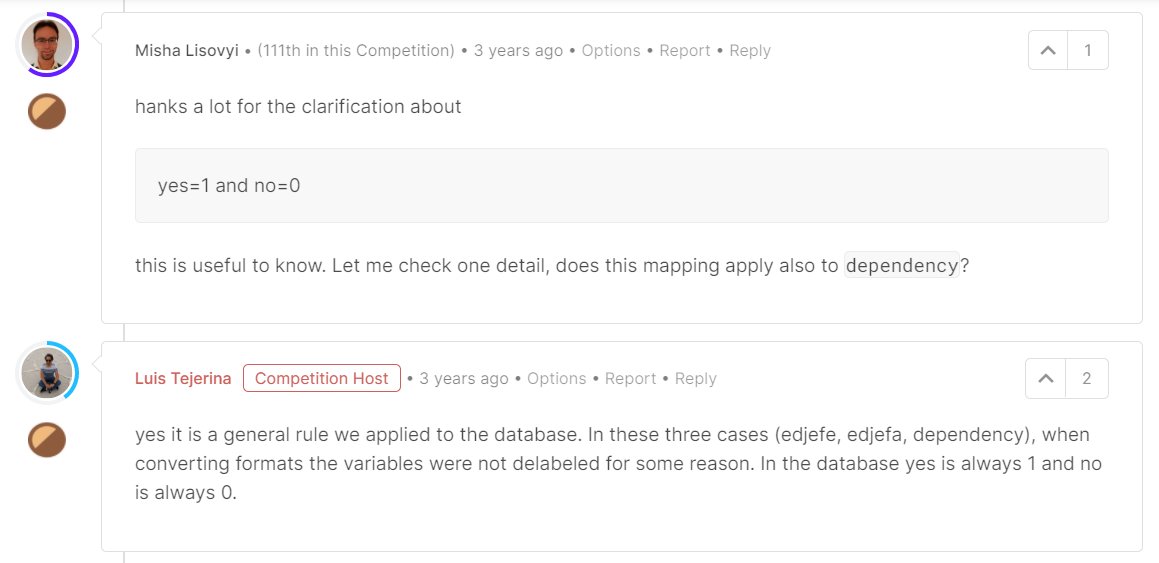
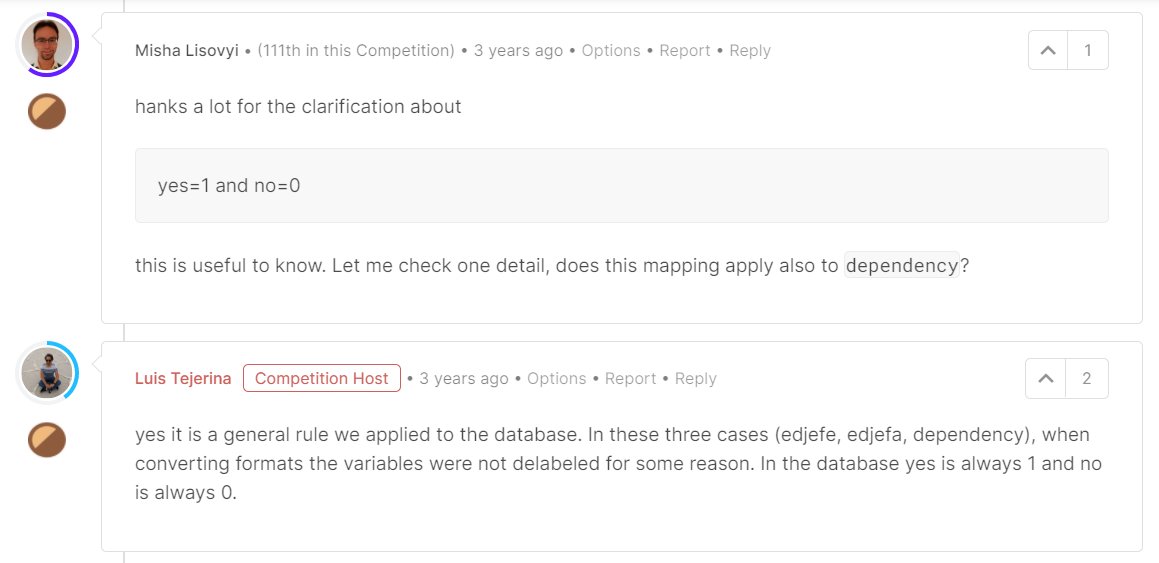

From the above discussion we can understand that 'yes = 1 and no = 0' for 'dependency', 'edjefe' and 'edjefa'

In [ ]:
mapping_dict={'yes':1,"no":0}
train_test['dependency'] = train_test['dependency'].replace(mapping_dict).astype(np.float64)
train_test['edjefe'] = train_test['edjefe'].replace(mapping_dict).astype("int")
train_test['edjefa'] = train_test['edjefa'].replace(mapping_dict).astype("int")
train_test['edjef'] = np.max(train_test[['edjefa','edjefe']], axis=1)


In [ ]:
print(train_test.dtypes.to_string())

In [ ]:
train_test.select_dtypes('object').head()

Now all the missing data are replaced with meaningful value. we can start to do eda and feature engineering.

In [ ]:
# convert to int if float but only has integer value
train_test['v18q1'] = train_test['v18q1'].astype("int")
train_test['rez_esc'] = train_test['rez_esc'].astype("int")

# Feature Engineering 

In [ ]:
from sklearn.preprocessing import LabelEncoder
def do_features(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                ]
    
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)       
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
    
    # aggregation rules over household
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']
               }
    
    aggs_cat = {'dis': ['mean']}
    for s_ in ['estadocivil', 'parentesco', 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean', 'count']

    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    # Drop id's
    #df.drop(['Id'], axis=1, inplace=True)
    
    return df
train_test = do_features(train_test)

In [ ]:
# convert one hot encoded fields to label encoding
from sklearn.preprocessing import LabelEncoder
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_:
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_:
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele'] #do for electricity also
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df
train_test = convert_OHE2LE(train_test)

In [ ]:
def convert_geo2aggs(df_):
    cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE', 
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']
    cols_nums = ['age', 'meaneduc', 'dependency', 
                 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
                 'bedrooms', 'overcrowding']

    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
                        pd.get_dummies(df_[cols_2_ohe], 
                                       columns=cols_2_ohe)],axis=1)

    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])
    
    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
train_test = convert_geo2aggs(train_test)

In [ ]:
train_test

In [ ]:

train_test['num_over_18'] = 0
train_test['num_over_18'] = train_test[train_test.age >= 18].groupby('idhogar').transform("count")
train_test['num_over_18'] = train_test.groupby("idhogar")["num_over_18"].transform("max")
train_test['num_over_18'] = train_test['num_over_18'].fillna(0)
# add some extra features, these were taken from another kernel
def extract_features(df):
    # add the number of people over 18 in each household
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1
    
extract_features(train_test)       

In [ ]:
train_test

In [ ]:
# drop duplicated columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

#instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

#needless_cols.extend(instlevel_cols)

train_test = train_test.drop(needless_cols, axis=1)

In [ ]:
test_final = train_test.loc[train_test["Target"].isnull()]
test_final = test_final.drop(['Target'], axis=1)
test_final = test_final.fillna(0)
test_final.to_csv(r'test_final_v1.csv', index = False)
test_final

In [ ]:
train_final = train_test.loc[train_test["Target"].notnull()]
train_final = train_final.fillna(0)
train_final.to_csv(r'train_final_v1.csv', index = False)
train_final

In [ ]:
cols_with_missing = [col for col in train_final.columns 
                                 if train_final[col].isnull().any()]
cols_with_missing

In [ ]:
train_final.loc[train_final['agg18_estadocivil1_MEAN'].isnull()]

In [ ]:
train_test.to_csv(r'train_test.csv', index = False)

In [ ]:
# train_test = pd.read_csv("../input/costa-rica/train_test.csv") # check for cleanliness Version 14

train = train_test.loc[~train_test['Target'].isnull()]
test = train_test.loc[train_test['Target'].isnull()]

test = test.drop(['Target'], axis=1)

original_test = pd.read_csv("../input/costa-rican-household-poverty-prediction/test.csv")

test_ids = original_test.Id

In [ ]:
# Need test id when exporting prediction result
# test_ids = test.Id

# But Id and idhogar are not needed during model building
train.drop(columns = ["Id", "idhogar"], inplace = True)
test.drop(columns = ["Id", "idhogar"], inplace = True)

train_length = train.shape[0]
test_length = test.shape[0]

In [ ]:
# Our subjects of interest are heads of household
# Hence, for training, we will only be using these subjects

# But for test data, we have to predict for both heads and non-heads,
# except that results for non-heads are not graded.
# Hence, we treat all the test data like heads of household for prediction purposes.

X = train[train.parentesco1 == 1].copy()
y = X['Target'] - 1
y = y.astype('int')
X.drop(['Target', "parentesco1"], axis=1, inplace = True)

test.drop(columns = ["parentesco1"], inplace = True)

# Feature Selection

In [ ]:
# Since our training data is so imbalanced, we shall not allocate the same weight to all target classes
# Instead, target classes that are more "rare" shall get higher weight
# y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)
y_weights = class_weight.compute_sample_weight('balanced', y, indices=None)

# Let's take a look
# Indeed, target class 1, which is the rarest, gets the highest weight
# Then weight decreases as the Target class becomes more common
# print(pd.DataFrame(dict(Target = y_train+1, Weight = y_train_weights)).drop_duplicates().sort_values(by = ["Target"]).reset_index(drop = True))
print(pd.DataFrame(dict(Target = y, Weight = y_weights)).drop_duplicates().sort_values(by = ["Target"]).reset_index(drop = True))

In [ ]:
def split_data(train, y, sample_weight=None, test_percentage=0.20):   
    # pick some random households to use for the test data
    test_idx = np.random.choice(train.index, size = int(train.shape[0] * test_percentage), replace = False)
    
    X_test = train.loc[test_idx]
    y_test = y.loc[test_idx]

    X_train = train.loc[~train.index.isin(test_idx)]
    y_train = y.loc[~train.index.isin(test_idx)]
    
    if sample_weight is not None:
        y_train_weights = sample_weight[~train.index.isin(test_idx)]
        return X_train, y_train, X_test, y_test, y_train_weights
    
    return X_train, y_train, X_test, y_test

In [ ]:
train_X, train_y, val_X, val_y, train_y_weights = split_data(X, y, y_weights, test_percentage = 0.30)

In [ ]:
def evaluate_macroF1_xgb(predictions, truth):  
    pred_labels = predictions.argmax(axis=1)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1) 

xgb_fit_params={"early_stopping_rounds":500,
                "eval_metric" : evaluate_macroF1_xgb, 
                'verbose': False,
               }

xgb_ = xgb.XGBClassifier(random_state=217, n_jobs=-1)
xgb_fit_params["eval_set"] = [(val_X,val_y)]
model = xgb_.fit(train_X, train_y, sample_weight = train_y_weights, **xgb_fit_params)
useless_xgb_cols = train_X.columns[model.feature_importances_ == 0].tolist()

In [ ]:
rf_ = RandomForestClassifier(random_state=217, n_jobs=-1)
rf_.fit(X, y)
useless_rf_cols = X.columns[rf_.feature_importances_ == 0].tolist()

In [ ]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(4,-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

lgb_fit_params={"early_stopping_rounds":500,
                "eval_metric" : evaluate_macroF1_lgb, 
                'verbose': False,
               }

lgb_fit_params["eval_set"] = [(val_X,val_y)]
lgb_ = lgb.LGBMClassifier(random_state = 217, n_jobs=-1)
model = lgb_.fit(train_X, train_y, sample_weight = train_y_weights, **lgb_fit_params)
useless_lgb_cols = X.columns[model.feature_importances_ == 0].tolist()

In [ ]:
print("XGBClassifier eliminated {} features".format(len(useless_xgb_cols)))
print("RandomForestClassifier eliminated {} features".format(len(useless_rf_cols)))
print("LGBMClassifier eliminated {} features".format(len(useless_lgb_cols)))

In [ ]:
xgb_opt_parameters = {'n_estimators':300, 'learning_rate':0.15, 'max_depth':35, 'eta':0.15, 
                      'objective':'multi:softmax', 'min_child_weight': 2, 'num_class': 4, 'gamma': 2.5, 
                      'colsample_bylevel': 1, 'subsample': 0.95, 'colsample_bytree': 0.85, 'reg_lambda': 0.35 }

rf_opt_parameters = {"max_depth": None, "n_estimators": 500, "min_impurity_decrease": 1e-3, 
                    "min_samples_leaf": 2, "class_weight": "balanced"}

lgb_opt_parameters = {'max_depth':45, "learning_rate":0.15, 'objective':'multiclass', 'silent':True, #'metric':evaluate_macroF1_lgb, 
                      'n_estimators':300, 'class_weight':'balanced','colsample_bytree': 0.89, 'min_child_samples':90, 
                      'num_leaves':20, 'subsample':0.96}

In [ ]:
xgbs = []
for i in range(0, 16):
    xgb_ = xgb.XGBClassifier(random_state=217+i, n_jobs=-1, **xgb_opt_parameters)
    train_X, train_y, val_X, val_y, train_y_weights = split_data(X.drop(columns = useless_xgb_cols), y, sample_weight= y_weights)
    xgb_fit_params["eval_set"] = [(val_X,val_y)]
    xgb_.fit(train_X, train_y, sample_weight = train_y_weights, **xgb_fit_params)
    xgbs.append(xgb_)

rfs = []
for i in range(0, 8):
    rf = RandomForestClassifier(random_state=217+i, n_jobs=-1, **rf_opt_parameters)  
    rf.fit(X.drop(useless_rf_cols, axis=1), y)
    rfs.append(rf)
    
lgbs = []
for i in range(0, 9):
    lgb_ = lgb.LGBMClassifier(random_state=217+i, n_jobs=-1, **lgb_opt_parameters)
    train_X, train_y, val_X, val_y  = split_data(X.drop(columns = useless_lgb_cols), y)
    lgb_fit_params["eval_set"] = [(val_X,val_y)]
    lgb_.fit(train_X, train_y, **lgb_fit_params)
    lgbs.append(lgb_)

In [ ]:
xgb_predictions_hard_test = []
for i in range(0, len(xgbs)):
    xgb_predictions_hard_test.append(xgbs[i].predict(test.drop(columns = useless_xgb_cols ).fillna(0)))
    
rf_predictions_hard_test = []
for i in range(0, len(rfs)):
    rf_predictions_hard_test.append(rfs[i].predict(test.drop(columns = useless_rf_cols ).fillna(0)))
    
lgb_predictions_hard_test = []
for i in range(0, len(lgbs)):
    lgb_predictions_hard_test.append(lgbs[i].predict(test.drop(columns = useless_lgb_cols).fillna(0)))  
    
xgb_predictions_soft_test = []
for i in range(0, len(xgbs)):
    xgb_predictions_soft_test.append(xgbs[i].predict_proba(test.drop(columns = useless_xgb_cols ).fillna(0)))
    
rf_predictions_soft_test = []
for i in range(0, len(rfs)):
    rf_predictions_soft_test.append(rfs[i].predict_proba(test.drop(columns = useless_rf_cols ).fillna(0)))
    
lgb_predictions_soft_test = []
for i in range(0, len(lgbs)):
    lgb_predictions_soft_test.append(lgbs[i].predict_proba(test.drop(columns = useless_lgb_cols ).fillna(0)))


In [ ]:
def generate_results(settings):
    num_of_xgbs = settings[0]
    num_of_rfs = settings[1]
    num_of_lgbs = settings[2]
    voting_type = settings[3]
    
    if voting_type == "Hard":
        all_predictions = []
        if len(xgb_predictions_hard_test[0:num_of_xgbs]) != 0:
            all_predictions.extend(xgb_predictions_hard_test[0:num_of_xgbs])
        if len(rf_predictions_hard_test[0:num_of_rfs]) != 0:
            all_predictions.extend(rf_predictions_hard_test[0:num_of_rfs])
        if len(lgb_predictions_hard_test[0:num_of_lgbs]) != 0:
            all_predictions.extend(lgb_predictions_hard_test[0:num_of_lgbs])
        combined_predictions = np.vstack(all_predictions).transpose()
        combined_predictions = pd.DataFrame(combined_predictions).mode(axis = 1)
        combined_predictions = combined_predictions.median(axis = 1).astype('int')
    
    if voting_type == "Soft":
        xgbs_predictions = sum(xgb_predictions_soft_test[0:num_of_xgbs])
        rfs_predictions = sum(rf_predictions_soft_test[0:num_of_rfs])
        lgbs_predictions = sum(lgb_predictions_soft_test[0:num_of_lgbs])
        combined_predictions = sum([xgbs_predictions, rfs_predictions, lgbs_predictions])
        combined_predictions = combined_predictions.argmax(axis = 1)

    return combined_predictions

In [ ]:
results = generate_results((7, 8, 9, 'Hard'))

In [ ]:
submission = pd.DataFrame(test_ids)
submission["Target"] = results + 1
submission.to_csv("submission.csv", index = False)